In [1]:
! pip install tensorflow matplotlib deepface scikit-learn numpy pandas


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
from keras.models import load_model
import time
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [4]:
def loadAllModels():
    """
    This function loads all the saved models

    Returns:
        Loaded saved models which are ready to be infered
    """
    tic = time.time()
    face_model = load_model('weights/action.h5', compile=False)
    toc = time.time()
    print('Time taken to load Face model: ', toc - tic, ' seconds')

    tic = time.time()
    gender_model = load_model('weights/action_gender.h5', compile=False)
    toc = time.time()
    print('Time taken to load Gender model: ', toc - tic, ' seconds')

    tic = time.time()
    age_model = load_model('weights/action_age.h5', compile=False)
    toc = time.time()
    print('Time taken to load Age model: ', toc - tic, ' seconds')

    tic = time.time()
    eth_model = load_model('weights/action_eth.h5', compile=False)
    toc = time.time()
    print('Time taken to load Ethnicity model: ', toc - tic, ' seconds')

    return face_model, gender_model, age_model, eth_model

In [5]:
face_model, gender_model, age_model, eth_model = loadAllModels()

Time taken to load Face model:  8.552437543869019  seconds
Time taken to load Gender model:  7.40500545501709  seconds
Time taken to load Age model:  8.199155569076538  seconds
Time taken to load Ethnicity model:  9.226842641830444  seconds


In [6]:
# Defining list of labels
persons = [str(num) for num in range(1, 103)]
persons.sort()
genders = ['female', 'male']
eths = ['black', 'east_asian', 'west_asian', 'white']
filters = ['Haircut Filter (FaceApp)', 'ChildFilter (FaceApp)', 'Gender Reverse Filter (FaceApp)',
               'Hipster Beard Style Filter (FaceApp)', 'Hair Color Blonde Filter (FaceApp)', 
               'Puppy Filter (B612)', 'So Sad Filter (B612)', 'Hipster Look Filter (Snapchat)',
                'Sparkling Cartoon Filter (Snapchat)', 'Body Mellow Glow Filter (Snapchat)']

# Setting the image dimensions for model input
img_height, img_width = 256, 256

In [7]:
def find(file_path):
    """
    This function predicts the best possible match of a face in the given dataset
    Args:
        file_path (str): file path to the image file to be preprocessed

    Returns:
        df:  pandas dataframe of predicted labels sorted in the order of probability
    """
    # Reading the input image and resizing to model input dimensions
    image = cv2.imread(file_path)
    image_resized = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)

    # Calculating processing time
    tic = time.time()
    pred = face_model.predict(image)[0]  # model inference
    # list of predicted labels sorted by probability
    identity_ids = np.flip(np.argsort(pred))
    # creating a dataframe to store predicted label with probabilities in sorted order
    data = []
    for i in identity_ids:
        data.append([persons[i], pred[i]])
    toc = time.time()

    processing_time = toc - tic
    print("Time taken = {} seconds".format(processing_time))
    columns = ['Predicted Label', 'Probability']
    df = pd.DataFrame(data=np.array(data), columns=columns)

    print("Predicted Label is: {} with probability = {}".format(
        df.iloc[0]['Predicted Label'], df.iloc[0]['Probability']))

    # returns the dataframe of possible predicted labels sorted in the order of probability
    return df

In [8]:
def findEuclideanDistance(source_representation, test_representation):
    """
    This function calculates the Euclidean distance between two given vectors
    Args:
        source_representation: vector representation of first face
        test_representation: vector representation of second face

    Returns:
        euclidean_distance: numpy array giving euclidean distance between the
                            given vector represntations
    """
    # if the input type is list, convert to numpy array
    if type(source_representation) == list:
        source_representation = np.array(source_representation)

    if type(test_representation) == list:
        test_representation = np.array(test_representation)

    # Calculating euclidean distance using formula
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(
        euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [9]:
def l2_normalize(vec):
    """
    This function calculates the L2-Norm of a given vector
    Args:
        vec: vector embedding

    Returns:
        l2_norm: numpy array representing L2 Normalized form of given vector
    """
    l2_norm = vec / np.sqrt(np.sum(np.multiply(vec, vec)))
    return l2_norm

In [10]:
def verify(file_path1, file_path2):
    """
    This function verifies if the given two images belong to the same person or not
    Args:
        file_path1 (str): file path to the first face image
        file_path2 (str): file path to the second face image        

    Returns:
        result: dictionary with two keys:
                'verified': bool value, true if faces are same else false
                'distance': distance value between input faces
    """

    # Reading the input images and resizing to model input dimensions
    image1 = cv2.imread(file_path1)
    image_resized1 = cv2.resize(image1, (img_height, img_width))
    image1 = np.expand_dims(image_resized1, axis=0)

    image2 = cv2.imread(file_path2)
    image_resized2 = cv2.resize(image2, (img_height, img_width))
    image2 = np.expand_dims(image_resized2, axis=0)

    # Calculating processing time
    tic = time.time()
    # model inference
    pred1 = face_model.predict(image1)
    pred2 = face_model.predict(image2)
    toc = time.time()

    # Calculating L2 normalized Euclidean distance between faces
    distance = findEuclideanDistance(l2_normalize(pred1), l2_normalize(pred2))

    # Initializing verified to default value of False
    verified = False

    # if distance between faces is less than threshold, then verified is True
    if distance < 0.75:
        verified = True

    processing_time = toc - tic
    print("Time taken = {} seconds".format(processing_time))
    result = {'verified': verified, 'distance': distance}
    return result

In [11]:
def analyze(file_path):
    """
    This function predicts the face identity, gender, age and ethnicity of the input face
    Args:
        file_path (str): file path to the image file to be preprocessed

    Returns:
        result: dictionary with the following keys:
                  'predicted_identity': Predicted face ID of the person,
                  'identity_probabilities': List of probabilities of best 5 matches,
                  'predicted_age': Predicted age of the person,
                  'predicted_gender': Predicted gender of the person,
                  'gender_probabilities': List of probabilities of all gender classes,
                  'predicted_ethnicity': Predicted ethnicity of the person,
                  'ethnicity_probabilities': List of probabilities of all ethnicity classes,
    """
    # Reading the input image and resizing to model input dimensions
    image = cv2.imread(file_path)
    image_resized = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)

    # Calculating processing time
    tic = time.time()
    pred = face_model.predict(image)[0]  # face model inference
    predicted_identity = persons[np.argmax(pred)]  # label with highest prob

    # Getting top 5 results
    identity_ids = np.flip(np.argsort(pred))
    identity = {}
    topK = 5
    for i in identity_ids:
        identity[persons[i]] = pred[i]
        topK -= 1
        if topK == 0:
            break
    
    baseline_img = "Dataset/Face Dataset/{}/{}.jpg".format(predicted_identity, predicted_identity)
    filtered_img = file_path
    
    verified_dict = verify(baseline_img, filtered_img)
    distance = verified_dict['distance']
    
    comments = ''
    if distance < 0.75:
        comments = 'The Filter DOES NOT produce significant distortion from the Baseline Image'
    else:
        comments = 'The Filter produces significant distortion from the Baseline Image'

    pred = gender_model.predict(image)[0]  # gender model inference
    # gender class with highest prob
    predicted_gender = genders[np.argmax(pred)]
    gender_ids = np.flip(np.argsort(pred))

    # Getting prob for each gender class
    gender = {}
    for i in gender_ids:
        gender[genders[i]] = pred[i]

    pred = eth_model.predict(image)[0]  # ethnicity model inference
    predicted_eth = eths[np.argmax(pred)]  # ethncity class with highest prob
    eth_ids = np.flip(np.argsort(pred))

    # Getting prob for each ethnicity class
    ethnicity = {}
    for i in eth_ids:
        ethnicity[eths[i]] = pred[i]

    pred = age_model.predict(image)  # age model inference
    age = round(pred[0][0])  # estimating the age to nearest integer

    toc = time.time()
    processing_time = toc - tic
    result = {'predicted_identity': predicted_identity,
              'comments on filter usability': comments,
              'identity_probabilities': identity,
              'predicted_age': age,
              'predicted_gender': predicted_gender,
              'gender_probabilities': gender,
              'predicted_ethnicity': predicted_eth,
              'ethnicity_probabilities': ethnicity
              }
    return result

In [12]:
df = pd.read_csv('Dataset/Attribute_Data/london_faces_info.csv')
df.head()

,face_id,face_age,face_gender,face_eth
0,1,24.0,female,white
1,2,24.0,female,white
2,3,38.0,female,white
3,4,30.0,male,white
4,5,28.0,male,east_asian


In [13]:
import os
data_dir = os.path.join("Dataset", "Image_Data")
person_no = 1
filter_no = 9
person_dir = os.path.join(data_dir, str(person_no)) 
filename = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))

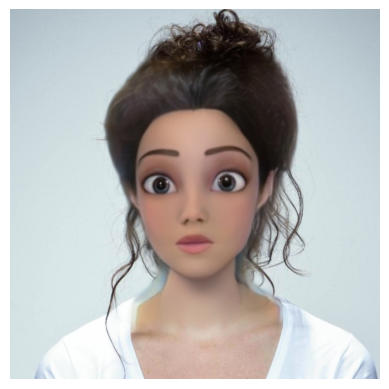

In [14]:
import matplotlib.pyplot as plt
img = cv2.imread(filename) 
plt.axis('off')
plt.imshow(img[:, :, ::-1])

In [15]:
df_face = find(filename)
print('Output of Find function for \nPerson ID - {} applied with Filter - {} is: '.format(person_no, filters[filter_no-1]))
df_face.head()

Time taken = 3.8861093521118164 seconds
Predicted Label is: 1 with probability = 0.86834764
Output of Find function for 
Person ID - 1 applied with Filter - Sparkling Cartoon Filter (Snapchat) is: 


,Predicted Label,Probability
0,1,0.86834764
1,89,0.06254816
2,87,0.042246353
3,19,0.0034985668
4,48,0.002537156


In [16]:
person_no1 = 1
filter_no1 = 1
person_dir1 = os.path.join(data_dir, str(person_no1)) 
filename1 = os.path.join(person_dir1, "{}_Filtered_{}.jpg".format(person_no1, filter_no1))

person_no2 = 1
filter_no2 = 7
person_dir2 = os.path.join(data_dir, str(person_no2)) 
filename2 = os.path.join(person_dir2, "{}_Filtered_{}.jpg".format(person_no2, filter_no2))

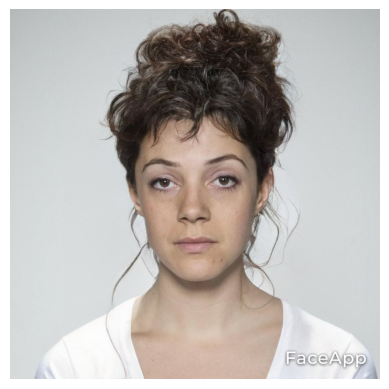

In [17]:
img1 = cv2.imread(filename1) 
plt.axis('off')
plt.imshow(img1[:, :, ::-1])

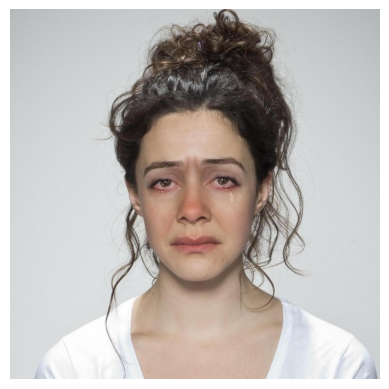

In [18]:
img2 = cv2.imread(filename2) 
plt.axis('off')
plt.imshow(img2[:, :, ::-1])

In [19]:
verification_dict = verify(filename1, filename2)
print('Output of Verify function for \nPerson ID - {} applied with Filter - {} and \nPerson ID - {} applied with Filter - {} is:\n'.format(person_no1, filters[filter_no1-1], person_no2, filters[filter_no2-1]))
for key in verification_dict.keys():
    print(key, ' : ', verification_dict[key])

Time taken = 0.7973475456237793 seconds
Output of Verify function for 
Person ID - 1 applied with Filter - Haircut Filter (FaceApp) and 
Person ID - 1 applied with Filter - So Sad Filter (B612) is:

verified  :  True
distance  :  0.012000506


In [22]:
analyze_dict = analyze(filename)
print('Details of Person ID - {}\n'.format(person_no))
print(df.iloc[person_no-1])
print('\nOutput of Analyze function for \nPerson ID - {} applied with Filter - {} is:\n'.format(person_no, filters[filter_no-1]))
for key in analyze_dict.keys():
    print(key, ' : ', analyze_dict[key])

Time taken = 0.6852905750274658 seconds
Details of Person ID - 1

face_id             1
face_age         24.0
face_gender    female
face_eth        white
Name: 0, dtype: object

Output of Analyze function for 
Person ID - 1 applied with Filter - Sparkling Cartoon Filter (Snapchat) is:

predicted_identity  :  1
comments on filter usability  :  The Filter DOES NOT produce significant distortion from the Baseline Image
identity_probabilities  :  {'1': 0.86834764, '89': 0.06254816, '87': 0.042246353, '19': 0.0034985668, '48': 0.002537156}
predicted_age  :  21
predicted_gender  :  female
gender_probabilities  :  {'female': 0.99999845, 'male': 1.5457215e-06}
predicted_ethnicity  :  white
ethnicity_probabilities  :  {'white': 0.9997454, 'east_asian': 0.0002534512, 'black': 1.0715753e-06, 'west_asian': 3.1160745e-09}
